In [1]:
import kaggle
import os
import numpy as np
import zipfile
import pandas as pd
import seaborn as sns
import pickle
from datetime import datetime
from sklearn.model_selection import RepeatedKFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, SCORERS
from math import sqrt

In [71]:
def submit_to_kaggle(predictions):
    submission_time = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
    predictions.to_csv("submissions/rfr_%f_%s.csv" % (sqrt(-clf.best_score_),submission_time),index=False)
    submission_file_path = os.path.abspath("submissions/rfr_%f_%s.csv" % (sqrt(-clf.best_score_),submission_time))
    submission = kaggle_api.competition_submit(competition=COMPETITION_NAME,
                                               file_name=submission_file_path,
                                               message="rfr_%f_%s" % (sqrt(-clf.best_score_),submission_time))
    print(submission)
    
def save_best_model(clf, model_name, model_version, completion_time):
    model_file_path = 'models/%s_v%i_%f_%s.model' % (model_name, model_version, sqrt(-clf.best_score_), completion_time)
    pickle.dump(clf.best_estimator_,open(model_file_path, 'wb'))
    
    pd.DataFrame(clf.cv_results_).to_csv('models/%s_v%i_%f_%s.csv' % (model_name, model_version, sqrt(-clf.best_score_), completion_time),
                                        index=False)
    
def build_model(model, model_name, model_version, parameter_grid, cross_validation, train, y_train):
    clf = GridSearchCV(estimator = model,
                          param_grid = parameter_grid,
                          scoring = 'neg_mean_squared_error',
                          n_jobs=-1,
                          iid=False,
                          cv=cross_validation,
                          return_train_score=True,
                          verbose=3)
    clf.fit(X = train,
            y = y_train)
    completion_time = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
    
    best_score = sqrt(-clf.best_score_)    
    save_best_model(clf, model_name, model_version, completion_time)
    
    feature_importance = pd.DataFrame({'features': train.columns,
                                       'importance': clf.best_estimator_.feature_importances_
                                      }).sort_values(by='importance',ascending=False)
    
    print("Model completion time: %s" % completion_time)
    print("Best cross validation score: %f" % best_score)
    print("Best parameters: %s" % clf.best_params_)
    
    return {
        "model": model,
        "model_name": model_name,
        "model_version": model_version,
        "best_parameters": clf.best_params_,
        "best_model": clf.best_estimator_,
        "best_score": best_score,
        "cv_results": pd.DataFrame(clf.cv_results_),
        "feature_importance": feature_importance
    } 


In [3]:
# Download data
COMPETITION_NAME = 'elo-merchant-category-recommendation'
DOWNLOAD_FILES = False
UNZIP_FILES = False

kaggle_api = kaggle.KaggleApi()
kaggle_api.authenticate()

if DOWNLOAD_FILES:
    kaggle_api.competition_download_files(competition=COMPETITION_NAME, path='data', quiet=False)

if UNZIP_FILES:
    for item in os.listdir('data',):
        if item.endswith('zip'):
            file_name = os.path.abspath('data/' + item)
            zip_ref = zipfile.ZipFile(file_name)
            zip_ref.extractall('data/')
            zip_ref.close()
            os.remove(file_name)

In [4]:
# Read data
merchants = pd.read_csv('data/merchants.csv')
new_trans = pd.read_csv('data/new_merchant_transactions.csv')
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')
hist_trans = pd.read_csv('data/historical_transactions.csv')

## Data manipulation

In [5]:
train['first_active_year'] = train.first_active_month.str[:4]
train['first_active_month_m'] = train.first_active_month.str[5:].astype('int')

test['first_active_month'].fillna('2017-06',inplace=True)
test['first_active_year'] = test.first_active_month.str[:4]
test['first_active_month_m'] = test.first_active_month.str[5:].astype('int')

## Explore train

In [6]:
train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'first_active_year', 'first_active_month_m'],
      dtype='object')

In [7]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_year,first_active_month_m
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,2017,6
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,2017,1
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,2016,8
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,2017,9
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,2017,11


In [8]:
test.iloc[11578]

first_active_month              2017-06
card_id                 C_ID_c27b4f80f7
feature_1                             5
feature_2                             2
feature_3                             1
first_active_year                  2017
first_active_month_m                  6
Name: 11578, dtype: object

In [9]:
test[test.isnull().any(axis=1)]

,first_active_month,card_id,feature_1,feature_2,feature_3,first_active_year,first_active_month_m


#### target

In [10]:
train.target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

In [11]:
train.groupby(pd.cut(train.target,[-40,-1,0,1,40])).agg('size')

target
(-40, -1]    45742
(-1, 0]      58566
(0, 1]       56709
(1, 40]      40900
dtype: int64

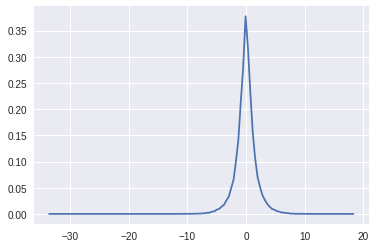

In [12]:
ax = sns.distplot(train[['target']], hist=False,rug = False)

Is normally distributed, half of data is between -1 and 1

#### first_active_month

In [13]:
print(train.first_active_month.min())
print(train.first_active_month.max())

2011-11
2018-02


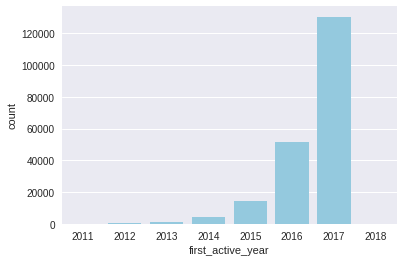

In [14]:
sns.countplot(x='first_active_year', data=train, color='skyblue')

[(-2.5, 2.5)]

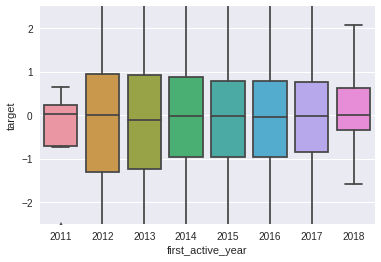

In [15]:
ax = sns.boxplot(x='first_active_year',y='target',data=train,orient='v')
ax.axes.set(ylim=(-2.5,2.5))

#### first_active_month_m

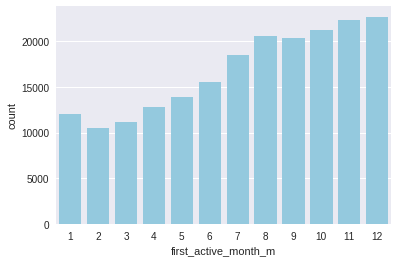

In [16]:
sns.countplot(x='first_active_month_m', data=train, color='skyblue')

In [17]:
year_months = train.groupby(['first_active_year','first_active_month_m']).size()
year_months.groupby('first_active_year').apply(lambda x: 100*x/x.sum()).groupby('first_active_month_m').mean()

first_active_month_m
1     19.471427
2      3.731123
3      4.763369
4      6.154659
5      7.960435
6      7.462820
7      9.419159
8     10.438816
9     10.586543
10    10.746234
11    22.075000
12    13.905195
dtype: float64

#### feature_1

In [18]:
temp = train.groupby('feature_1').size().reset_index(name='count')
temp['proportion'] = temp['count']/temp['count'].sum()
temp

,feature_1,count,proportion
0,1,12037,0.059614
1,2,55797,0.276336
2,3,73573,0.364372
3,4,19885,0.098481
4,5,40625,0.201197


[(-10, 10)]

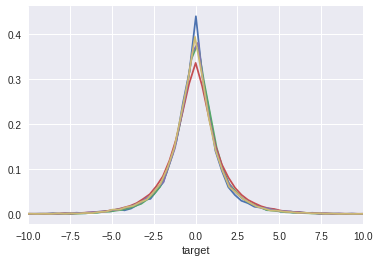

In [19]:
sns.distplot(train[train.feature_1==1].target, hist=False)
sns.distplot(train[train.feature_1==2].target, hist=False)
sns.distplot(train[train.feature_1==3].target, hist=False)
sns.distplot(train[train.feature_1==4].target, hist=False)
sns.distplot(train[train.feature_1==5].target, hist=False).set(xlim=[-10,10])

In [20]:
train.groupby('feature_1').target.agg('describe')

,count,mean,std,min,25%,50%,75%,max
feature_1,,,,,,,,
1,12037.0,-0.315476,3.407106,-33.219281,-0.810411,-0.011003,0.666923,15.011358
2,55797.0,-0.350452,3.756032,-33.219281,-0.806444,0.000000,0.768908,13.592223
3,73573.0,-0.377533,3.834499,-33.219281,-0.956521,-0.036539,0.837927,15.606405
4,19885.0,-0.404652,3.817954,-33.219281,-0.856211,0.000000,0.728345,9.665204
5,40625.0,-0.499879,4.134833,-33.219281,-0.895946,-0.056208,0.692869,17.965068


#### feature_2

In [21]:
temp = train.groupby('feature_2').target.agg('describe').reset_index()
temp['count_proportion'] = temp['count']/sum(temp['count'])
temp

,feature_2,count,mean,std,min,25%,50%,75%,max,count_proportion
0,1,89242.0,-0.398675,3.890548,-33.219281,-0.822850,-0.002394,0.738072,17.965068,0.441974
1,2,74839.0,-0.332899,3.567683,-33.219281,-0.946076,-0.045086,0.799371,15.606405,0.370642
2,3,37836.0,-0.501889,4.269270,-33.219281,-0.902546,-0.033784,0.766570,13.350895,0.187384


#### feature_3

In [22]:
train.groupby('feature_3').target.agg('describe').reset_index()

,feature_3,count,mean,std,min,25%,50%,75%,max
0,0,87719.0,-0.357939,3.724459,-33.219281,-0.817775,0.000000,0.745114,15.011358
1,1,114198.0,-0.421057,3.944379,-33.219281,-0.934403,-0.044637,0.783653,17.965068


### Look at hist_trans

In [32]:
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [34]:
hist_trans.purchase_date.max()

'2018-02-28 23:59:51'

In [31]:
new_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [39]:
new_trans.purchase_date.max()

(1963031, 14)

In [43]:
len(merchants.merchant_id.unique())

334633

### Build models

In [52]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=11)

In [72]:
rfr_params = {
    'max_depth':[5]
}
results = build_model(model = RandomForestRegressor(random_state=11,n_estimators=100),
            model_name = "random_forest", 
            model_version = 1,
            parameter_grid = rfr_params,
            cross_validation = rkf, 
            train = train.drop(['target','card_id','first_active_month'],axis=1),
            y_train = train.target)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.0s remaining:   24.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.1s finished


Model completion time: 2019_01_22_21_41_09
Best cross validation score: 3.841844
Best parameters: {'max_depth': 5}


In [73]:
results['cv_results']

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,11.314886,0.269462,-14.759763,-14.739633,5,{'max_depth': 5},1,-15.260013,-14.616528,-14.531805,...,-15.087817,-14.655802,-14.505445,-14.804243,-14.413735,-14.826073,3.097153,0.041069,0.344745,0.085967


In [74]:
results['feature_importance']

,features,importance
4,first_active_month_m,0.457870
3,first_active_year,0.320042
1,feature_2,0.113736
0,feature_1,0.075614
2,feature_3,0.032738


#### Fit best estimator model to test set

In [58]:
test.head()

Index(['feature_1', 'feature_2', 'feature_3', 'first_active_year',
       'first_active_month_m'],
      dtype='object')

In [139]:
predictions = pd.Series(clf.best_estimator_.predict(test.drop(['card_id','first_active_month'],axis=1)))
test_predictions = pd.concat([test.card_id,predictions],axis=1)
test_predictions.rename(columns={0:'target'},inplace=True)

In [146]:
submit_to_kaggle(test_predictions)

100%|██████████| 4.30M/4.30M [00:03<00:00, 1.15MB/s]


Successfully submitted to Elo Merchant Category Recommendation


In [147]:
kaggle_api.competition_submissions_cli(competition=COMPETITION_NAME)

fileName                              date                 description                       status    publicScore  privateScore  
------------------------------------  -------------------  --------------------------------  --------  -----------  ------------  
rfr_3.841905_2019_01_22_08_57_13.csv  2019-01-22 08:57:18  rfr_3.841905_2019_01_22_08_57_13  complete  3.921        None          
rfr_3.841905_2019_01_22_08_53_14.csv  2019-01-22 08:53:18  rfr_3.841905_2019_01_22_08_53_14  complete  3.921        None          
rfr_3.841905_2019_01_22_08_51_48.csv  2019-01-22 08:51:53  rfr_3.841905_2019_01_22_08_51_48  error     None         None          
rfr_3.841905_2019_01_22_08_46_16.csv  2019-01-22 08:46:21  rfr_3.841905_2019_01_22_08_46_16  error     None         None          
